# HWRS 528 IMP03
## Build Catchment Model

### 1. Import Python Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 2. Define Function Subprograms
#### 2.1 Catchment model subprograms

In [123]:
#==== Linear reservoir module (for one time step) ================================

def LinRes(Xin, U, Kpar):                   # Define LinRes function subprogram

    Y = Kpar*Xin                            # Compute QQ
    Xout = Xin - Y + U                      # Update state variable

    return [Y, Xout]                        # Return computed quantities

#==== Channel routing module (for one time step) ====================================================

def NashCasc(OF, NRes, XX3in, Theta_K3Q):   # Define NashCasc function subprogram

    ResIdx = np.arange(0, NRes, 1)          # Set loop vector on tanks (int values)
    UU     = OF                             # UU is set to be input to first tank
    XX3out = np.zeros(NRes)                 # Initialize array to recieve XX3out
    YY     = np.zeros(NRes)                 # Initialize array to recieve YY (individual tank outflows)

    for i in ResIdx:
        [YY[i], XX3out[i]] = LinRes(XX3in[i], UU, Theta_K3Q)
        UU = YY[i]                          # set UU (inflow to next tank) to be outflow from previous tank
    SF = UU                                 # Get output from last tank

    return [SF, XX3out]                     # Return computed quantities (surface flow and state variable of last tank)

#==== Lower Soil Zone Module (for one time step) ======================================================

def LowerSoilZone(XX2in, RG, Theta_K2Q):    # Calculate lower soil zone subprocesses using LinRes

    [BF, XX2out] = LinRes(XX2in, RG, Theta_K2Q) # Use Recharge as input for LSZ from upper soil zone tank
    return [BF, XX2out]

#==== Upper Soil Zone Module (for one time step) ======================================================

def UpperSoilZone(XX1in, PP, PE, Theta_C1, Theta_P1, Theta_K13, Theta_K12):
    
    PX   = np.maximum(0, PP + XX1in - Theta_C1)   # Determines excess precipitation, part 1 of OF
    IF   = Theta_K13*XX1in                        # Determines lateral drainage, part 2 of OF
    OF   = PX + IF                                # Overland flow that will become the input for NashCasc
    XX1a = XX1in - IF                             # Remainder of water content (Method of Operator Splitting)
    AE   = np.minimum(XX1a, PE*(XX1a/Theta_C1)**Theta_P1) # Actual evaporation limited by PE or water content
    XX1b = XX1a - AE                              # Remainder of water content 
    RG   = Theta_K12*XX1b                         # Recharge
    XX1c = XX1b - RG                              # Remainder of water content
    XX1out = XX1c + PP - PX                       # State variable at end of time step

    return [OF, PX, IF, AE, RG, XX1out]

#==== Catchment Model (for one time step) ======================================================

def CatchModel(Inputs, InStates, Pars, NRes):

    # Get input values for time step
    PP = Inputs[0]
    PE = Inputs[1]

    # Get state values at beginning of time step
    XX1in  = InStates[0]
    XX2in  = InStates[1]
    XX3in  = np.zeros(NRes)
    ResIdx = np.arange(0, NRes, 1)
    for i in ResIdx:
        XX3in[i] = InStates[i+2]

    # Get Par values
    Theta_C1  = Pars[0]
    Theta_P1  = Pars[1]
    Theta_K12 = Pars[2]
    Theta_K13 = Pars[3]
    Theta_K2Q = Pars[4]
    Theta_K3Q = Pars[5]

    # Initialize Output array
    Outputs   = np.zeros(2)
    OutStates = np.zeros(NRes+2)
    IntFluxes = np.zeros(6)

    # Run model components
    [OF, PX, IF, AE, RG, XX1out] = UpperSoilZone(XX1in, PP, PE,
                                                Theta_C1, Theta_P1,
                                                Theta_K13, Theta_K12)
    [BF, XX2out] = LowerSoilZone(XX2in, RG, Theta_K2Q)
    [SF, XX3out] = NashCasc(OF, NRes, XX3in, Theta_K3Q)
    QQ           = SF + BF

    # Compile outputs for time step
    Outputs[0] = QQ
    Outputs[1] = AE

    # Compile and get state values at end of time step
    OutStates[0] = XX1out
    OutStates[1] = XX2out
    for i in ResIdx:
        OutStates[i+2] = XX3out[i]

    # Compile internal fluxes for time step
    IntFluxes[0] = OF; IntFluxes[1] = PX; IntFluxes[2] = IF
    IntFluxes[3] = RG; IntFluxes[4] = BF; IntFluxes[5] = SF

    return [Outputs, OutStates, IntFluxes]

def MainCatchModel(PPobs, PEobs, Theta_C1,
                   Theta_P1, Theta_K12, Theta_K13,
                   Theta_K2Q, Theta_K3Q, NRes):
    
    
    NTime = len(PPobs)              # Get length of time vector
    Time  = np.arange(0, NTime, 1)  # Set up time vector (of integer values)

    # Pack parameter values in Par array
    Npar = 6; Pars = np.zeros(Npar)
    Pars[0] = Theta_C1;  Pars[1] = Theta_P1;  Pars[2] = Theta_K12
    Pars[3] = Theta_K13; Pars[4] = Theta_K2Q; Pars[5] = Theta_K3Q

    # Initialize model state arrays
    InStates = np.zeros(NRes+2); OutStates = InStates.copy()
    InStates[1] = QQobs[0]/Theta_K2Q

    # Initialize arrays
    Inputs = np.zeros(2); Outputs = np.zeros(2); IntFluxes = np.zeros(6)
    QQsim  = np.zeros(NTime); AEsim = np.zeros(NTime)

    OF = np.zeros(NTime); PX = np.zeros(NTime); IF = np.zeros(NTime)
    RG = np.zeros(NTime); BF = np.zeros(NTime); SF = np.zeros(NTime)
    XX1 = np.zeros(NTime+1); XX2 = np.zeros(NTime+1)
    XX3 = np.zeros([NTime+1, NRes])

    for t in Time:
        Inputs[0] = PPobs[t]; Inputs[1] = PEobs[t]
        [Outputs, OutStates, IntFluxes] = CatchModel(Inputs, InStates, Pars, NRes)

        QQsim[t] = Outputs[0].copy(); AEsim[t] = Outputs[1].copy()
        OF[t] = IntFluxes[0]; PX[t] = IntFluxes[1]; IF[t] = IntFluxes[2]
        RG[t] = IntFluxes[3]; BF[t] = IntFluxes[4]; SF[t] = IntFluxes[5]
        XX1[t+1] = OutStates[0]; XX2[t+1] = OutStates[1]
        ResIdx = np.arange(0, NRes, 1)
        for i in ResIdx:
            XX3[t+1, i] = OutStates[i+2]
        InStates = OutStates
    # use the below commented line when evaluating model state variables
    # return [QQsim, AEsim, XX1, XX2, XX3]
    return [QQsim, AEsim]

#### 2.2 Metric Subprograms

In [113]:
#==== Compute Mean Square Error (MSE) ========================================

def MSE_Fn(Qs,Qo):                  # Define MSE_Fn function subprograms
    MSE = np.mean((Qs-Qo)**2)       # Compute MSE
    return MSE

#==== Compute NSE Metric

def NSE_Fn(Qs, Qo):                 # Define NSE_Fn function subprograms
    MSE = MSE_Fn(Qs,Qo)             # Compute MSE
    NSE = 1 - (MSE/np.var(Qo))      # Compute NSE
    return NSE

#==== Compute KGE Metric =====================================================

def KGE_Fn(Qs,Qo):                  # Define KGE_Fn function subprogram
    alpha = np.std(Qs)/np.std(Qo)                               # compute alpha
    beta  = np.mean(Qs)/np.mean(Qo)                             # compute beta
    rho   = np.corrcoef(Qs,Qo)[0,1]                             # compute rho
    KGE   = 1 - np.sqrt((1-alpha)**2 + (1-beta)**2 + (1-rho)**2)# compute KGE
    KGEss = (KGE - (1-np.sqrt(2)))/np.sqrt(2)                   # compute KGEss
    return [KGEss, KGE, alpha, beta, rho]   # Return compute quantities

#==== Compute all of the performance metrics (calls metric functions) ========

def PerfMetrics(QQsim, QQobs, SpinUp, iPrint):

    Qs   = QQsim[SpinUp:NTime].copy()                   # remove spin-up period
    Qo   = QQobs[SpinUp:NTime].copy()                   # remove spin-up period
    MSE  = MSE_Fn(Qs, Qo)                               # Compute MSE
    NSE  = NSE_Fn(Qs, Qo)                               # Compute NSE
    NSEL = NSE_Fn(np.log(Qs), np.log(Qo))               # Compute NSEL
    [KGEss, KGE, alpha, beta, rho] = KGE_Fn(Qs, Qo)     # Compute KGE & components

    # Create lables for printing
    MSELab = f'MSE = {MSE:.2f}'; NSELab = f'NSE = {NSE:.2f}'
    KGEssLab = f'KGEss = {KGEss:.2f}'; RhoLab = f'Rho = {rho:.2f}'
    AlphaLab = f'Alpha = {alpha:.2f}'; BetaLab = f'Beta = {beta:.2f}'
    NSELLab = f'NSEL = {NSEL:.2f}'

    if iPrint == 1: # print following lines only if the iPrint Flag is set to 1
        print()
        print('================================================================')
        print(MSELab, NSELab, KGEssLab, AlphaLab, BetaLab, RhoLab, NSELLab)
        print('================================================================')

    return [MSE,NSE,NSEL,KGEss,KGE,alpha,beta,rho]

##### 2.3 Diagnostics Plots subprograms

In [114]:
#==== Create Diagnostic Plots ===========================================================

def DiagnosticPlots(fignum,Time,QQsim,QQobs):
    
    MuQQsim = np.mean(QQsim);                                    # Compute mean of QQsim
    MuQQobs = np.mean(QQobs);                                    # Compute mean of QQobs
    SigQQsim = np.std(QQsim);                                    # Compute std  of QQsim
    SigQQobs = np.std(QQobs);                                    # Compute std  of QQobs
    rho     = np.corrcoef(QQsim,QQobs)[0, 1];                    # Compute Rho
    rho_srt = np.corrcoef(np.sort(QQsim),np.sort(QQobs))[0, 1];  # Compute Rho of sorted
    Lab1 = f'Mu_sim = {MuQQsim:.2f}, Sig_sim = {SigQQsim:.2f}'   # Create Labels
    Lab2 = f'Mu_obs = {MuQQobs:.2f}, Sig_obs = {SigQQobs:.2f}'   # Create Labels
 
    QQsimL    = np.log(QQsim);                                   # Create Log(QQsim)
    QQobsL    = np.log(QQobs);                                   # Create Log(QQobs)
    MuQQsimL  = np.mean(QQsimL);                                 # Compute mean of QQsimL
    MuQQobsL  = np.mean(QQobsL);                                 # Compute mean of QQobsL
    SigQQsimL = np.std(QQsimL);                                  # Compute std  of QQsimL
    SigQQobsL = np.std(QQobsL);                                  # Compute std  of QQobsL
    rhoL      = np.corrcoef(QQsimL,QQobsL)[0, 1];                   # Compute Rho
    rho_srtL  = np.corrcoef(np.sort(QQsimL),np.sort(QQobsL))[0,1];  # Compute Rho of sorted
    Lab1L = f'Mu_simL = {MuQQsimL:.2f}, Sig_simL = {SigQQsimL:.2f}' # Create Labels
    Lab2L = f'Mu_obsL = {MuQQobsL:.2f}, Sig_obsL = {SigQQobsL:.2f}' # Create Labels

    # First Row of Plots
    plt.figure(num = fignum);                                # Set figure number
    fig_width = 14; fig_height = 4;                          # Set figure width and height
    fig, ax1 = plt.subplots(nrows=1,ncols=1,\
                            figsize=(fig_width,fig_height)); # Create figure
    Period_Start = Time[0]; Period_End = Time[-1];           # Set plot time period
    # Time Series Plot
    ax1.set_xlim(Period_Start,Period_End);                   # Fix xaxis limits
    ax1.set_xlabel('Time (Days)');                           # Set the x-axis label
    ax1.set_ylabel('QQ (mm)');                               # Set the x-axis label
    ax1.set_title('CatchModel: Time Series Plot');           # Add plot title
    ax1.grid('k--');                                         # Turn on grid lines
    B = [0,1.5*np.max(QQobs)];                               # Get the y-axis limits 
    ax1.set_ylim(B);                                         # Set the y-axis limits
    color1 = 'r.'; color2 = 'b';                             # Choose line color
    ax1.plot(Time,QQobs,color1,label="QQ observed");         # Plots the Observed Flows
    ax1.plot(Time,QQsim,color2,label="QQ simulated");        # Plots the Simulated Flows
    ax1.legend(loc=2);
    
    # Second Row of Plots
    fignum = fignum + 1;
    plt.figure(num = fignum);                                # Set figure number
    fig_width = 14; fig_height = 6.5;                        # Set figure width and height
    fig, ax2 = plt.subplots(nrows=1,ncols=2,\
                            figsize=(fig_width,fig_height)); # Create figure
    # Scatterplot
    ax2[0].set_xlabel('QQobs',color='r');                    # Set the x-axis label
    ax2[0].set_ylabel('QQsim',color='b');                    # Set the y-axis label
    ax2[0].grid('k--');                                      # Turn on grid lines
    B = [0,1.25*np.max(QQobs)];                              # Get the axis limits 
    ax2[0].set_xlim(B);                                      # Set the x-axis limits
    ax2[0].set_ylim(B);                                      # Set the y-axis limits
    ax2[0].plot(QQobs,QQsim,'k.');                           # Plots a scatterplot
    ax2[0].plot(B,B,'k:');                                   # Plot 1:1 line
    ax2[0].set_title(f'Rho = {rho:.2f}');                    # Add plot title
    ax2[0].plot(B,[MuQQsim,MuQQsim],'b:',label = Lab1);
    ax2[0].tick_params(axis='y',labelcolor = 'b');           # Set the yaxis tick color
    ax2[0].plot([MuQQobs,MuQQobs],B,'r:',label = Lab2);
    ax2[0].tick_params(axis='x',labelcolor = 'r');           # Set the xaxis tick color
    ax2[0].legend(loc=2);
    # Q-Q Plot
    ax2[1].set_xlabel('sort(QQobs)',color='r');              # Set the x-axis label
    ax2[1].set_ylabel('sort(QQsim)',color='b');              # Set the y-axis label
    ax2[1].grid('k--');                                      # Turn on grid lines
    B = [0,1.25*np.max(QQobs)];                              # Get the axis limits 
    ax2[1].set_xlim(B);                                      # Set the x-axis limits
    ax2[1].set_ylim(B);                                      # Set the y-axis limits
    ax2[1].plot(np.sort(QQobs),np.sort(QQsim),'k.');         # Plots a Q-Q Plot
    ax2[1].plot(B,B,'k:');                                   # Plot 1:1 line
    ax2[1].set_title(f'Rho = {rho_srt:.2f}');                # Add plot title
    #ax2[1].plot(B,[MuQQsim,MuQQsim],'b:',label = Lab1);
    ax2[1].tick_params(axis='y',labelcolor = 'b');           # Set the yaxis tick color
    #ax2[1].plot([MuQQobs,MuQQobs],B,'r:',label=Lab2);
    ax2[1].tick_params(axis='x',labelcolor = 'r');           # Set the xaxis tick color
    #ax2[1].legend(loc=2);

    #Third Row of Plots
    fignum = fignum + 1;    
    plt.figure(num = fignum);                               # Set figure number
    fig_width = 14; fig_height = 4;                         # Set figure width and height
    fig, ax3 = plt.subplots(nrows=1,ncols=1,\
                            figsize=(fig_width,fig_height)); # Create figure
    # Time Series Log Plot
    ax3.set_xlim(Period_Start,Period_End);                # Fix xaxis limits
    ax3.set_xlabel('Time (Days)');                        # Set the x-axis label
    ax3.set_ylabel('Log(QQ)');                            # Set the x-axis label
    ax3.set_title('CatchModel: Time Series Plot');        # Add plot title
    ax3.grid('k--');                                      # Turn on grid lines
    B = [0.1,1.5*np.max(QQobs)];                          # Get the y-axis limits 
    ax3.set_ylim(B);                                      # Set the y-axis limits
    color1 = 'r.'; color2 = 'b';                          # Choose line color
    ax3.semilogy(Time,QQobs,color1,label="QQ observed");  # Plots the Observed Flows
    ax3.semilogy(Time,QQsim,color2,label="QQ simulated"); # Plots the Simulated Flows
    ax3.legend(loc=2);

    # Fourth Row of Plots
    fignum = fignum + 1;
    plt.figure(num = fignum);                                # Set figure number
    fig_width = 14; fig_height = 6.5;                        # Set figure width and height
    fig, ax4 = plt.subplots(nrows=1,ncols=2,\
                            figsize=(fig_width,fig_height)); # Create figure
    # Scatterplot
    ax4[0].set_xlabel('Log(QQobs)',color='r');               # Set the x-axis label
    ax4[0].set_ylabel('Log(QQsim)',color='b');               # Set the y-axis label
    ax4[0].grid('k--');                                      # Turn on grid lines
    B = [0.1,1.25*np.max(QQobs)];                            # Get the axis limits 
    ax4[0].set_xlim(B);                                      # Set the x-axis limits
    ax4[0].set_ylim(B);                                      # Set the y-axis limits
    ax4[0].loglog(QQobs,QQsim,'k.');                         # Plots a scatterplot
    ax4[0].loglog(B,B,'k:');                                 # Plot 1:1 line
    ax4[0].set_title(f'Rho = {rhoL:.2f}');                   # Add plot title
    ax4[0].loglog(B,[MuQQsim,MuQQsim],'b:',label = Lab1L);
    ax4[0].tick_params(axis='y',labelcolor = 'b');           # Set the yaxis tick color
    ax4[0].loglog([MuQQobs,MuQQobs],B,'r:',label = Lab2L);
    ax4[0].tick_params(axis='x',labelcolor = 'r');           # Set the xaxis tick color
    ax4[0].legend(loc=2);
    # Q-Q Plot
    ax4[1].set_xlabel('sort(Log(QQobs)',color='r');          # Set the x-axis label
    ax4[1].set_ylabel('sort(Log(QQsim))',color='b');         # Set the y-axis label
    ax4[1].grid('k--');                                      # Turn on grid lines
    B = [0.1,1.25*np.max(QQobs)];                            # Get the axis limits 
    ax4[1].set_xlim(B);                                      # Set the x-axis limits
    ax4[1].set_ylim(B);                                      # Set the y-axis limits
    ax4[1].loglog(np.sort(QQobs),np.sort(QQsim),'k.');       # Plots a Q-Q Plot
    ax4[1].loglog(B,B,'k:');                                 # Plot 1:1 line
    ax4[1].set_title(f'Rho = {rho_srtL:.2f}');               # Add plot title
    #ax4[1].plot(B,[MuQQsim,MuQQsim],'b:',label = Lab1);
    ax4[1].tick_params(axis='y',labelcolor = 'b');           # Set the yaxis tick color
    #ax4[1].plot([MuQQobs,MuQQobs],B,'r:',label=Lab2);
    ax4[1].tick_params(axis='x',labelcolor = 'r');           # Set the xaxis tick color
    #ax4[1].legend(loc=2);
    
    return

##### 2.4 Paramter Perturbation Analysis Plotting Subprograms

In [115]:
#==== Create Parameter Perturbation Plots for 5 metrics ======================

def ParPertPlot5Mets(ilog, fignum, PCurrent, PVals, PLab, YRange3, YRange2,
                     NSE, KGEss, rho, alpha, beta,
                     loc_opt_NSE, loc_opt_KGEss, loc_opt_rho, loc_opt_alpha, loc_opt_beta):
    
    NSECol   = 'r'
    KGEssCol = 'b'
    rhoCol   = 'k'
    alphaCol = 'g'
    betaCol  = 'm'
    CurrCol  = 'lightGrey'

    plt.figure(num = fignum)
    fig_width = 12; fig_height = 4
    fig, ax = plt.subplots(nrows=1, ncols=2,
                           figsize=(fig_width,fig_height))
    
    ax[0].set_xlim(min(PVals),max(PVals));               # Fix xaxis limits
    ax[0].set_xlabel(PLab);                              # Set the x-axis label
    ax[0].set_title('Variation of Metrics with '+PLab);  # Add plot title
    ax[0].grid();                                        # Turn on grid lines
    ax[0].set_ylim(YRange3);                             # Set the (left) y-axis limits
    ax[0].set_ylabel('Metric Value');                    # Set the y-axis label
    C1 = [PCurrent,PCurrent];                            # Get current values for par 
    C1label=f" Now at {PCurrent:.4f}";                   # Create label
    A1 = [PVals[loc_opt_NSE],PVals[loc_opt_NSE]];        # Get x-values of Par for optimal NSE 
    A1label=f"NSE Opt at {PVals[loc_opt_NSE]:.4f}";      # Create legend item
    A2 = [PVals[loc_opt_KGEss],PVals[loc_opt_KGEss]];    # Get x-values of Par for optimal KGEss 
    A2label=f"KGEss Opt at {PVals[loc_opt_KGEss]:.4f}";  # Create legend item
    A3 = [PVals[loc_opt_rho],PVals[loc_opt_rho]];        # Get x-values of Par for optimal KGEss 
    A3label=f"Rho Opt at {PVals[loc_opt_rho]:.4f}";      # Create legend item

    if ilog == 0:
        ax[0].plot(C1,YRange3,CurrCol,linewidth=5,label = C1label); # Draw vertical line at current par
        ax[0].plot(A1,YRange3,NSECol+'--');               # Draw vertical line at optimal par
        ax[0].plot([min(PVals),max(PVals)],[0,0],'k:');   # Draw horizontal line at metric=0
        ax[0].plot(PVals,NSE,color=NSECol,label=A1label); # Generate a "line" plot for NSE
        ax[0].plot(PVals,NSE,NSECol+'.');                 # Add dots to the line
        ax[0].plot(A2,YRange3,KGEssCol+'--');             # Draw vertical line at optimal par
        ax[0].plot(PVals,KGEss,color=KGEssCol,label=A2label); # Generate a "line" plot for KGEss
        ax[0].plot(PVals,KGEss,KGEssCol+'.');             # Add dots to the line
        ax[0].plot(A3,YRange3,rhoCol+'--');               # Draw vertical line at optimal par
        ax[0].plot(PVals,rho,color=rhoCol,label=A3label); # Generate a "line" plot for KGEss
        ax[0].plot(PVals,rho,rhoCol+'.');                 # Add dots to the line
    else:
        ax[0].semilogx(C1,YRange3,CurrCol,linewidth=5,label = C1label); # Draw vertical line at current par
        ax[0].semilogx(A1,YRange3,NSECol+'--');               # Draw vertical line at optimal par
        ax[0].semilogx([min(PVals),max(PVals)],[0,0],'k:');   # Draw horizontal line at metric=0
        ax[0].semilogx(PVals,NSE,color=NSECol,label=A1label); # Generate a "line" plot for NSE
        ax[0].semilogx(PVals,NSE,NSECol+'.');                 # Add dots to the line
        ax[0].semilogx(A2,YRange3,KGEssCol+'--');             # Draw vertical line at optimal par
        ax[0].semilogx(PVals,KGEss,color=KGEssCol,label=A2label); # Generate a "line" plot for KGEss
        ax[0].semilogx(PVals,KGEss,KGEssCol+'.');             # Add dots to the line
        ax[0].semilogx(A3,YRange3,rhoCol+'--');               # Draw vertical line at optimal par
        ax[0].semilogx(PVals,rho,color=rhoCol,label=A3label); # Generate a "line" plot for KGEss
        ax[0].semilogx(PVals,rho,rhoCol+'.');                 # Add dots to the line

    ax[0].legend(loc = 4);                            # Set legend location to upper left
    
    ax[1].set_xlim(min(PVals),max(PVals));               # Fix xaxis limits
    ax[1].set_xlabel(PLab);                              # Set the x-axis label
    ax[1].set_title('Variation of Metrics with '+PLab);  # Add plot title
    ax[1].grid();                                        # Turn on grid lines
    ax[1].set_ylim(YRange2);                             # Set the (left) y-axis limits
    ax[1].set_ylabel('Metric Value');                    # Set the y-axis label
    
    A4 = [PVals[loc_opt_alpha],PVals[loc_opt_alpha]];    # Get x-values of Par for optimal NSE 
    A4label=f"Alpha Opt at {PVals[loc_opt_alpha]:.4f}";  # Create legend item
    A5 = [PVals[loc_opt_beta],PVals[loc_opt_beta]];      # Get x-values of Par for optimal KGEss 
    A5label=f"Beta Opt at {PVals[loc_opt_beta]:.4f}";    # Create legend item

    if ilog == 0:
        ax[1].plot(C1,YRange2,CurrCol,linewidth=5);           # Draw vertical line at current par
        ax[1].plot([min(PVals),max(PVals)],[1,1],'k:');       # Draw horizontal line at metric=1
        ax[1].plot(A4,YRange2,alphaCol+'--');                 # Draw vertical line at optimal par
        ax[1].plot(PVals,alpha,color=alphaCol,label=A4label); # Generate a "line" plot for NSE
        ax[1].plot(PVals,alpha,alphaCol+'.');                 # Add dots to the line
        ax[1].plot(A5,YRange2,betaCol+'--');                  # Draw vertical line at optimal par
        ax[1].plot(PVals,beta,color=betaCol,label=A5label);   # Generate a "line" plot for KGEss
        ax[1].plot(PVals,beta,betaCol+'.');                   # Add dots to the line
    else:
        ax[1].semilogx(C1,YRange2,CurrCol,linewidth=5);           # Draw vertical line at current par
        ax[1].semilogx([min(PVals),max(PVals)],[1,1],'k:');       # Draw horizontal line at metric=1
        ax[1].semilogx(A4,YRange2,alphaCol+'--');                 # Draw vertical line at optimal par
        ax[1].semilogx(PVals,alpha,color=alphaCol,label=A4label); # Generate a "line" plot for NSE
        ax[1].semilogx(PVals,alpha,alphaCol+'.');                 # Add dots to the line
        ax[1].semilogx(A5,YRange2,betaCol+'--');                  # Draw vertical line at optimal par
        ax[1].semilogx(PVals,beta,color=betaCol,label=A5label);   # Generate a "line" plot for KGEss
        ax[1].semilogx(PVals,beta,betaCol+'.');                   # Add dots to the line
        
    ax[1].legend(loc = 1);                            # Set legend location to upper left

    return

#==== Create One-D Parameter Perturbation Vectors for ParPert Analysis ==================

def ParPertInit(Theta_Range,Step):
    
    # Set up locations to test
    NVal = int(1+((Theta_Range[1]-Theta_Range[0])/Step));
    PVals = np.linspace(Theta_Range[0],Theta_Range[1],num = NVal);
    IndexVal = np.arange(0,NVal,1);
    
    #Initialize metric vectors
    MSE = np.zeros(NVal); NSE = MSE.copy(); NSEL = MSE.copy(); 
    KGE = MSE.copy(); KGEss = MSE.copy(); alpha = MSE.copy(); 
    beta = MSE.copy(); rho = MSE.copy(); 
    
    return [NVal,PVals,IndexVal,MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho]

#==== Find and Store Locations of Optimal Pars for Various Metrics ======================

def OptParStore(MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho):
    
    # Store array location of optimal parameter value for different metrics
    loc_opt_MSE   = np.argmin(MSE);
    loc_opt_NSE   = np.argmax(NSE); 
    loc_opt_KGEss = np.argmax(KGEss);
    loc_opt_KGE   = np.argmax(KGE);
    loc_opt_alpha = np.argmax(1-abs(1-alpha));
    loc_opt_beta  = np.argmax(1-abs(1-beta));
    loc_opt_rho   = np.argmax(rho);
    
    return [loc_opt_MSE,loc_opt_NSE,loc_opt_KGEss,loc_opt_KGE,\
            loc_opt_alpha,loc_opt_beta,loc_opt_rho]


### 3. Begin Model Simulation for Leaf River
##### 3.1 Load data, choose time periods, and specify model parameters

In [193]:
#==== Load Leaf River Catchment Data as a DataFrame ============================
LRData = pd.read_csv('LeafRiverDaily.csv')

#==== Get number of data points ================================================
Ndata = LRData.shape[0]
Nvars = LRData.shape[1]

#==== Choose simulation time period and set up time vector =====================
Period_Start = 0; Period_End = 365*3                # select time period to work with
Time = np.arange(Period_Start, Period_End, 1)
NTime = len(Time)

#==== Set number of initial time steps to use as spin-up =======================
# Metrics are not computed on this period
SpinUp = 90                                         # select 90-day spin-up period

#==== Get data for the desired period ==========================================
PPobs = LRData.PP[Time].to_numpy()                  # Convert from DataFrame to numpy
PEobs = LRData.PE[Time].to_numpy()                  # arrays to avoid indexing issyes
QQobs = LRData.QQ[Time].to_numpy()

#==== Determine maximum values for each variable ===============================
PPobs_max = np.max(PPobs)
PEobs_max = np.max(PEobs)
QQobs_max = np.max(QQobs)

#==== Specify model parameters =================================================
NRes = 2; ResIdx = np.arange(0, NRes, 1)

ParFlag = 2

if ParFlag == 0:
    #==== Initial model parameter guesses ==========================================

    Theta_C1  = np.mean([10,300])
    Theta_P1  = np.mean([0.5,1.5])
    Theta_K12 = np.mean([0,0.5])
    Theta_K13 = np.mean([0.2,0.9])
    Theta_K2Q = 10**np.mean([np.log10(.1), np.log10(0.0001)])
    Theta_K3Q = np.mean([0.1,0.9])

elif ParFlag == 1:
    #==== 1st guess after perturbation analysis ===================================
    Theta_C1  = 23.0;    # Upper Soil Zone Capacity
    Theta_P1  = 0.1;     # Evapotranspiration Parameter (Reducing value increases ET)  
    Theta_K12 = 0.50;    # Drainage to Lower Soil Zone (Increasing value increases Drainage) 
    Theta_K13 = 0.15;    # Interflow Parameter (Increasing value increases Interflow)  
    Theta_K2Q = 0.0001;  # Baseflow Parameter (Increasing value makes baseflow recessions steeper) 
    Theta_K3Q = 0.8;     # Channel Routing Parameter (Increasing value reduces temporal dispersion)

elif ParFlag == 2:
    #====2nd guess after perturbation analysis ===================================
    Theta_C1  = 51.0;    # Upper Soil Zone Capacity
    Theta_P1  = 0.75;     # Evapotranspiration Parameter (Reducing value increases ET)  
    Theta_K12 = 0.2;    # Drainage to Lower Soil Zone (Increasing value increases Drainage) 
    Theta_K13 = 0.04;    # Interflow Parameter (Increasing value increases Interflow)  
    Theta_K2Q = 0.0002;  # Baseflow Parameter (Increasing value makes baseflow recessions steeper) 
    Theta_K3Q = 0.56;     # Channel Routing Parameter (Increasing value reduces temporal dispersion)

elif ParFlag == 3:
    #==== Specify model parameter values for simulation ============================
    Theta_C1  = 60.0;    # Upper Soil Zone Capacity
    Theta_P1  = 1.0;     # Evapotranspiration Parameter (Reducing value increases ET)  
    Theta_K12 = 0.2;    # Drainage to Lower Soil Zone (Increasing value increases Drainage) 
    Theta_K13 = 0.10;    # Interflow Parameter (Increasing value increases Interflow)  
    Theta_K2Q = 0.0001;  # Baseflow Parameter (Increasing value makes baseflow recessions steeper) 
    Theta_K3Q = 0.5;     # Channel Routing Parameter (Increasing value reduces temporal dispersion)

print(f'Theta_C1: {Theta_C1}\nTheta_P1: {Theta_P1}\nTheta_K12: {Theta_K12}\nTheta_K13: {Theta_K13}\nTheta_K2Q: {Theta_K2Q}\nTheta_K3Q {Theta_K3Q}')

Theta_C1: 51.0
Theta_P1: 0.75
Theta_K12: 0.2
Theta_K13: 0.04
Theta_K2Q: 0.0002
Theta_K3Q 0.56


##### 3.2 Run Catchment Model for Selected Time Period and View Metrics

In [194]:
# Run Catchment Model for Selected time period ================================
#      use the below commented version when trying to capture the model state variables
# [QQsim, AEsim, XX1, XX2, XX3] = MainCatchModel(PPobs, PEobs, Theta_C1, Theta_P1, Theta_K12,
#                                 Theta_K13, Theta_K2Q, Theta_K3Q, NRes)
[QQsim, AEsim] = MainCatchModel(PPobs, PEobs, Theta_C1, Theta_P1, Theta_K12,
                                Theta_K13, Theta_K2Q, Theta_K3Q, NRes)
# Compute Performance Metrics for Selected Period =======================================
# Print Metrics
iPrint = 1; # Turn on print flag
[MSE,NSE,NSEL,KGEss,KGE,alpha,beta,rho] = PerfMetrics(QQsim,QQobs,SpinUp,iPrint)



MSE = 3.88 NSE = 0.71 KGEss = 0.88 Alpha = 0.96 Beta = 1.05 Rho = 0.85 NSEL = 0.30


##### 3.3 View Diagnostic Plots for Visual Evaluation & Manual Calibration

In [ ]:
#==== Time series plots for system states and AE =======================

XX31 = XX3[1:,0]                                        # Set data for first reservoir
XX32 = XX3[1:,1]                                        # Set data for second reservoir

States = [XX1[1:], XX2[1:], XX31, XX32, AEsim]          # Order the state variables to be plotted
StateLab = ['XX1', 'XX2', 'XX31', 'XX32', 'AEsim']      # Create labels for state variables
color = ['orangered','gold','chartreuse','royalblue','fuchsia'] # Set colors for state variables
NStates = len(States)                                   # Get number of state variables to be plotted
StateIdx = np.arange(0, NStates, 1)                     # Create state variable index for looping
Period_Start = Time[0]; Period_End = Time[-1];          # Reset plot time period

fig_width = 14; fig_height = 14;                        # Set figure width and height
fig, ax = plt.subplots(nrows=NStates,                   # Arrange figure to plot state variables
                       ncols =1,
                       figsize = (fig_width, fig_height),
                       constrained_layout=True)
fig.suptitle('State Variables of the Leaf River Catchment\n(first three years)', fontsize=16)
fig.set_facecolor('whitesmoke')

for i in StateIdx:                                      # Plot state variables
    ax[i].plot(Time, States[i], color=color[i])
    ax[-1].set_xlabel('Time (days)')
    ax[i].set_ylabel(' Water Head (mm)')
    ax[i].set_title(StateLab[i])
    ax[i].grid('--k')
    ax[i].set_xlim(Period_Start,Period_End)

plt.savefig('imp03_images/stateVars_first3yrs')         # save generated image
plt.plot()

<Figure size 432x288 with 0 Axes>

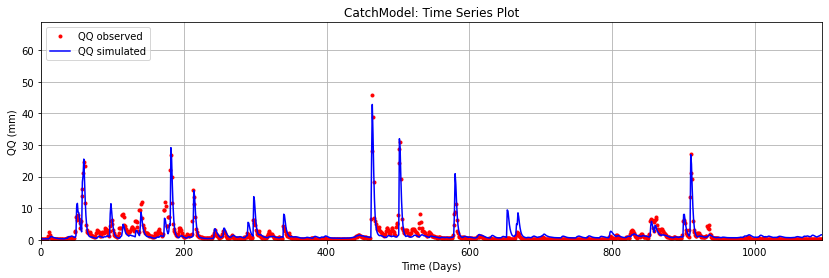

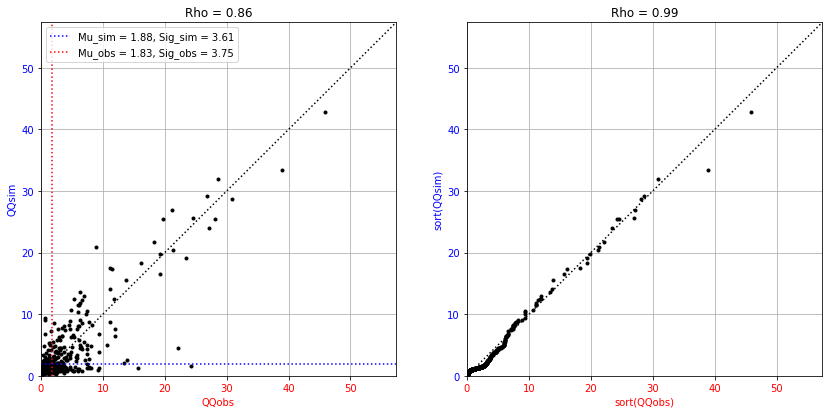

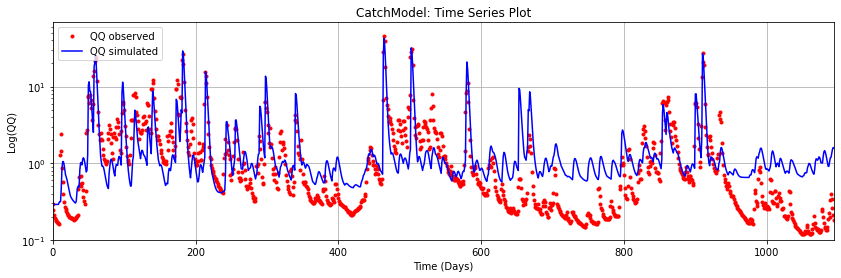

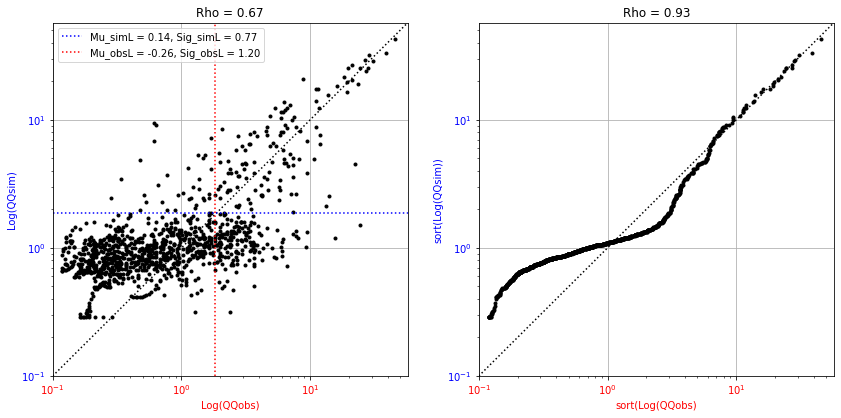

In [195]:
#==== Show Diagnostic Plots ===================================================

fignum = 0; iPrint = 1                              # set figure number
if iPrint == 1:
    DiagnosticPlots(fignum, Time, QQsim, QQobs)     # show diagnostic plots

##### 3.4 Run OAT Parameter Perturbation Analysis

<Figure size 432x288 with 0 Axes>

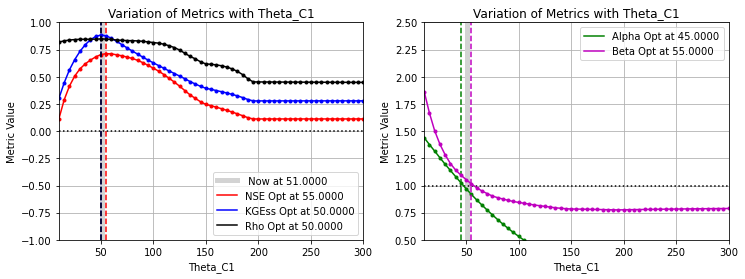

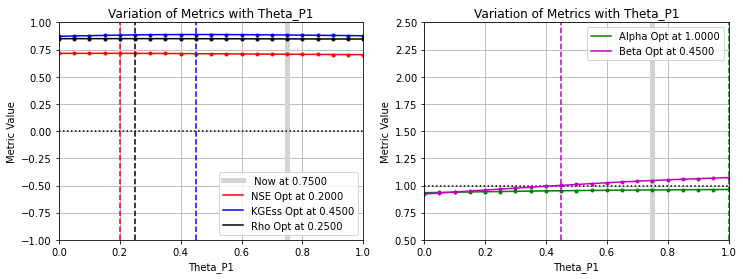

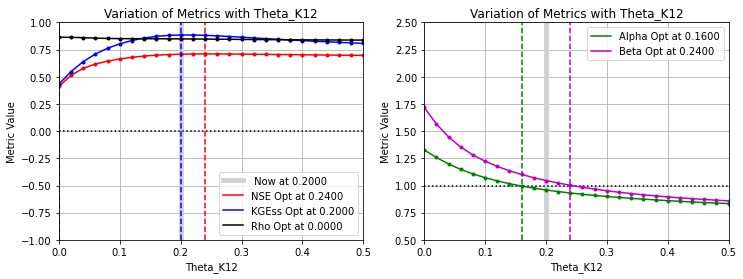

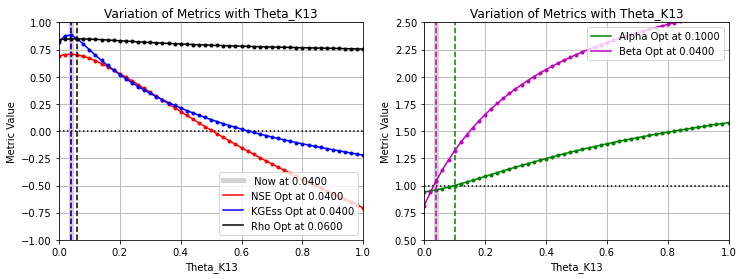

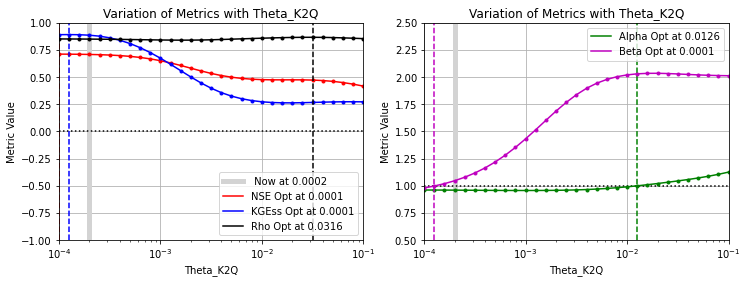

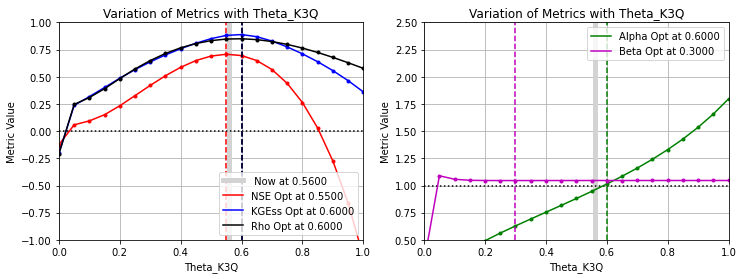

In [196]:
#=== Run OAT Parameter Perturbation Analysis ============================================

YRange3 = [-1.0,1.0]; YRange2 = [0.5,2.5];   # Set y-axis ranges for Metric Plots

# Parameter Theta_C1
fignum = fignum + 1; PLab = 'Theta_C1';
Theta_C1_Range = [10,300]; Step = 5; #YRange3 = [0.2,1]; YRange2 = [0.8,1.8];
[NVal,PVals,IndexVal,MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho] = ParPertInit(Theta_C1_Range,Step);
for i in IndexVal:
    [QQsim,AEsim] = MainCatchModel(PPobs,PEobs,\
                    PVals[i],Theta_P1,Theta_K12,Theta_K13,Theta_K2Q,Theta_K3Q,NRes);  
    [MSE[i],NSE[i],NSEL[i],KGEss[i],KGE[i],alpha[i],beta[i],rho[i]] = PerfMetrics(QQsim,QQobs,SpinUp,0);
[loc_opt_MSE,loc_opt_NSE,loc_opt_KGEss,loc_opt_KGE,loc_opt_alpha,\
        loc_opt_beta,loc_opt_rho] = OptParStore(MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho);
ParPertPlot5Mets(0,fignum,Theta_C1,PVals,PLab,YRange3,YRange2,\
                 NSE,KGEss,rho,alpha,beta,\
                 loc_opt_NSE,loc_opt_KGEss,loc_opt_rho,loc_opt_alpha,loc_opt_beta);

                 # Parameter Theta_P1
fignum = fignum + 1; PLab = 'Theta_P1';
Theta_P1_Range = [0,1]; Step = 0.05; #YRange3 = [0.2,1]; YRange2 = [0.8,1.8];
[NVal,PVals,IndexVal,MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho] = ParPertInit(Theta_P1_Range,Step);
for i in IndexVal:
    [QQsim,AEsim] = MainCatchModel(PPobs,PEobs,\
                    Theta_C1,PVals[i],Theta_K12,Theta_K13,Theta_K2Q,Theta_K3Q,NRes);  
    [MSE[i],NSE[i],NSEL[i],KGEss[i],KGE[i],alpha[i],beta[i],rho[i]] = PerfMetrics(QQsim,QQobs,SpinUp,0);
[loc_opt_MSE,loc_opt_NSE,loc_opt_KGEss,loc_opt_KGE,loc_opt_alpha,\
        loc_opt_beta,loc_opt_rho] = OptParStore(MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho);
ParPertPlot5Mets(0,fignum,Theta_P1,PVals,PLab,YRange3,YRange2,\
                 NSE,KGEss,rho,alpha,beta,\
                 loc_opt_NSE,loc_opt_KGEss,loc_opt_rho,loc_opt_alpha,loc_opt_beta); 

# Parameter Theta_K12
fignum = fignum + 1; PLab = 'Theta_K12';
Theta_K12_Range = [0,0.5]; Step = 0.02; #YRange3 = [0.2,1]; YRange2 = [0.8,1.8];
[NVal,PVals,IndexVal,MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho] = ParPertInit(Theta_K12_Range,Step);
for i in IndexVal:
    [QQsim,AEsim] = MainCatchModel(PPobs,PEobs,\
                    Theta_C1,Theta_P1,PVals[i],Theta_K13,Theta_K2Q,Theta_K3Q,NRes);  
    [MSE[i],NSE[i],NSEL[i],KGEss[i],KGE[i],alpha[i],beta[i],rho[i]] = PerfMetrics(QQsim,QQobs,SpinUp,0);
[loc_opt_MSE,loc_opt_NSE,loc_opt_KGEss,loc_opt_KGE,loc_opt_alpha,\
        loc_opt_beta,loc_opt_rho] = OptParStore(MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho);
ParPertPlot5Mets(0,fignum,Theta_K12,PVals,PLab,YRange3,YRange2,\
                 NSE,KGEss,rho,alpha,beta,\
                 loc_opt_NSE,loc_opt_KGEss,loc_opt_rho,loc_opt_alpha,loc_opt_beta); 

# Parameter Theta_K13
fignum = fignum + 1; PLab = 'Theta_K13';
Theta_K13_Range = [0,1]; Step = 0.02; #YRange3 = [0.2,1]; YRange2 = [0.8,1.8];
[NVal,PVals,IndexVal,MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho] = ParPertInit(Theta_K13_Range,Step);
for i in IndexVal:
    [QQsim,AEsim] = MainCatchModel(PPobs,PEobs,\
                    Theta_C1,Theta_P1,Theta_K12,PVals[i],Theta_K2Q,Theta_K3Q,NRes);  
    [MSE[i],NSE[i],NSEL[i],KGEss[i],KGE[i],alpha[i],beta[i],rho[i]] = PerfMetrics(QQsim,QQobs,SpinUp,0);
[loc_opt_MSE,loc_opt_NSE,loc_opt_KGEss,loc_opt_KGE,loc_opt_alpha,\
        loc_opt_beta,loc_opt_rho] = OptParStore(MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho);
ParPertPlot5Mets(0,fignum,Theta_K13,PVals,PLab,YRange3,YRange2,\
                 NSE,KGEss,rho,alpha,beta,\
                 loc_opt_NSE,loc_opt_KGEss,loc_opt_rho,loc_opt_alpha,loc_opt_beta); 

# Parameter Theta_K2Q (**** ON log10 X-AXIS ****)
fignum = fignum + 1; PLab = 'Theta_K2Q';
Theta_K2Q_Range = [-4,-1]; Step = 0.1; #YRange3 = [0.2,1]; YRange2 = [0.8,1.8];
[NVal,PVals,IndexVal,MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho] = ParPertInit(Theta_K2Q_Range,Step);
for i in IndexVal:
    PVals[i] = 10**PVals[i];
    [QQsim,AEsim] = MainCatchModel(PPobs,PEobs,\
                    Theta_C1,Theta_P1,Theta_K12,Theta_K13,PVals[i],Theta_K3Q,NRes);  
    [MSE[i],NSE[i],NSEL[i],KGEss[i],KGE[i],alpha[i],beta[i],rho[i]] = PerfMetrics(QQsim,QQobs,SpinUp,0);
[loc_opt_MSE,loc_opt_NSE,loc_opt_KGEss,loc_opt_KGE,loc_opt_alpha,\
        loc_opt_beta,loc_opt_rho] = OptParStore(MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho);
ParPertPlot5Mets(1,fignum,Theta_K2Q,PVals,PLab,YRange3,YRange2,\
                 NSE,KGEss,rho,alpha,beta,\
                 loc_opt_NSE,loc_opt_KGEss,loc_opt_rho,loc_opt_alpha,loc_opt_beta);

# Parameter Theta_K3Q
fignum = fignum + 1; PLab = 'Theta_K3Q';
Theta_K3Q_Range = [0.0,1.0]; Step = 0.05; #YRange3 = [0.2,1]; YRange2 = [0.8,1.8];
[NVal,PVals,IndexVal,MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho] = ParPertInit(Theta_K3Q_Range,Step);
for i in IndexVal:
    [QQsim,AEsim] = MainCatchModel(PPobs,PEobs,\
                    Theta_C1,Theta_P1,Theta_K12,Theta_K13,Theta_K2Q,PVals[i],NRes);  
    [MSE[i],NSE[i],NSEL[i],KGEss[i],KGE[i],alpha[i],beta[i],rho[i]] = PerfMetrics(QQsim,QQobs,SpinUp,0);
[loc_opt_MSE,loc_opt_NSE,loc_opt_KGEss,loc_opt_KGE,loc_opt_alpha,\
        loc_opt_beta,loc_opt_rho] = OptParStore(MSE,NSE,NSEL,KGE,KGEss,alpha,beta,rho);
ParPertPlot5Mets(0,fignum,Theta_K3Q,PVals,PLab,YRange3,YRange2,\
                 NSE,KGEss,rho,alpha,beta,\
                 loc_opt_NSE,loc_opt_KGEss,loc_opt_rho,loc_opt_alpha,loc_opt_beta); 